<a href="https://colab.research.google.com/github/Preetirai-tech/Brain-Tumor-Detection/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import cv2
import os
import random
import math, shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")


In [3]:
DIR = '/content/drive/MyDrive/Brain tumor detection/datasets'

num_of_images = {}

for dir in os.listdir(DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(DIR, dir)))

num_of_images.items()

dict_items([('no', 1500), ('yes', 1500)])

Splited the data such that
  * 70% for Train data
  * 15% for Validation
  * 15% for Testing

In [4]:
def create_data_folder(folder_name, split):
  if not os.path.exists('./' + folder_name):
    os.mkdir('./' + folder_name)

    for dir in os.listdir(DIR):
      os.makedirs('./' + folder_name + '/' + dir)

      for img in np.random.choice(a = os.listdir(os.path.join(DIR, dir)), 
                                  size = (math.floor(split * num_of_images[dir])-2), 
                                  replace = False):
        file_path = os.path.join(DIR, dir, img)
        file = os.path.join('./' + folder_name, dir)
        shutil.copy(file_path, file)
        os.remove(file_path)

  else:
    print(f'{path} folder exists')



In [5]:
create_data_folder('train', 0.7)

In [6]:
create_data_folder('val', 0.15)

In [7]:
create_data_folder('test', 0.15)

In [8]:
num_of_images = {}

for dir in os.listdir(DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(DIR, dir)))

num_of_images.items()

dict_items([('no', 6), ('yes', 6)])

### Data Preprocessing

In [10]:
# Preprocessing for train data
def preprocessingImages1(path):
  """
  Input: Path
  Output: Preprocessed images
  """
  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1/255, horizontal_flip = True)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32, class_mode = 'binary')

  return image

In [11]:
path = '/content/train'
train_data = preprocessingImages1(path)

Found 2096 images belonging to 2 classes.


In [35]:
train_data.batch_size

32

In [12]:
# Preprocessing for validation and test data
def preprocessingImages2(path):
  """
  Input: Path
  Output: Preprocessed images
  """
  image_data = ImageDataGenerator(rescale = 1/255)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32, class_mode = 'binary')
  
  return image

In [13]:
path = '/content/test'
test_data = preprocessingImages2(path)

Found 446 images belonging to 2 classes.


In [14]:
path = '/content/val'
val_data = preprocessingImages2(path)

Found 446 images belonging to 2 classes.


### Model Build

In [36]:
# CNN Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size= (3,3), activation= 'relu', input_shape = (224, 224, 3)))

model.add(Conv2D(filters = 36, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation= 'sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 110, 110, 36)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 52, 52, 128)      

In [37]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [38]:
# Early stopping

es = EarlyStopping(monitor='val_loss', 
                   #min_delta= 0.01,
                   patience= 3,
                   verbose= 1,
                   mode = 'auto',
                   baseline=None,
                   restore_best_weights=False)

# Model check point

mc = ModelCheckpoint(monitor='val_loss',
                   filepath= './bestmodel.h5',
                   verbose=1,
                   save_best_only= True,
                   mode = 'auto')

cb = [es, mc]

### Model Training

In [39]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size
history = model.fit(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs= 100, verbose= 1, 
                    validation_data= val_data,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks= cb)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6609
Epoch 1: val_loss improved from inf to 0.51622, saving model to ./bestmodel.h5
65/65 [==============================] - 31s 447ms/step - loss: 0.6439 - accuracy: 0.6609 - val_loss: 0.5162 - val_accuracy: 0.7332
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.5374 - accuracy: 0.7330
Epoch 2: val_loss improved from 0.51622 to 0.42725, saving model to ./bestmodel.h5
65/65 [==============================] - 30s 466ms/step - loss: 0.5374 - accuracy: 0.7330 - val_loss: 0.4272 - val_accuracy: 0.8365
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.4673 - accuracy: 0.7984
Epoch 3: val_loss did not improve from 0.42725
65/65 [==============================] - 30s 461ms/step - loss: 0.4673 - accuracy: 0.7984 - val_loss: 0.4325 - val_accuracy: 0.8125
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8222
Epoch 4: val_lo

In [40]:
# Model Graphical Interpretation

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

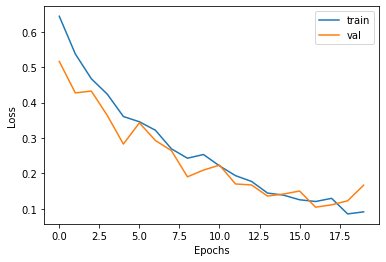

In [44]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


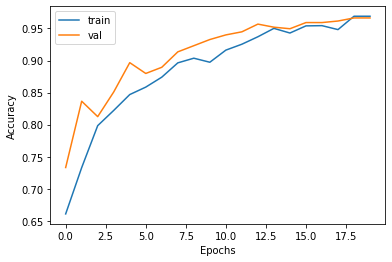

In [45]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [46]:
# Load model

model = load_model('/content/bestmodel.h5')


### Model Accuracy

In [66]:
#test_data[1]

In [63]:
acc = model.evaluate_generator(test_data)[1]

print(f'The accuracy of the model is {acc * 100} %')

The accuracy of the model is 97.30941653251648 %


In [50]:
import tensorflow as tf

In [70]:
train_data.class_indices

{'no': 0, 'yes': 1}

In [77]:
def predict_tumor(path):

  img = tf.keras.preprocessing.image.load_img(path, target_size = (224, 224))
  input_array = tf.keras.preprocessing.image.img_to_array(img)/255


  plt.imshow(input_array)
  plt.show()

  #print(input_array.shape)

  input_array = np.expand_dims(input_array, axis = 0)

  pred = model.predict(input_array)#[0][0]
  #print(pred)
  print()
  if pred >= 0.5:
    print('The MRI image is of Brain Tumor')

  else:
    print('The MRI is of Healthy brain')

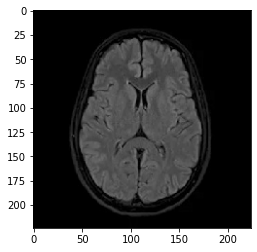

1/1 [==============================] - 0s 20ms/step

The MRI is of Healthy brain


In [79]:
path = '/content/drive/MyDrive/Brain tumor detection/pred/pred0.jpg'
predict_tumor(path)

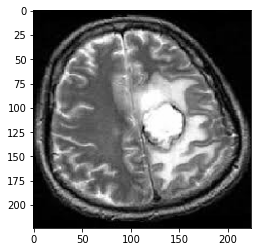

1/1 [==============================] - 0s 21ms/step

The MRI image is of Brain Tumor


In [80]:
path = '/content/drive/MyDrive/Brain tumor detection/pred/pred2.jpg'
predict_tumor(path)

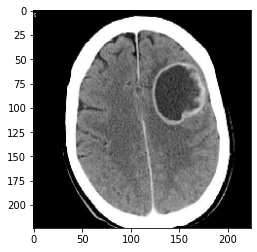

1/1 [==============================] - 0s 21ms/step

The MRI image is of Brain Tumor


In [81]:
path = '/content/drive/MyDrive/Brain tumor detection/pred/pred10.jpg'
predict_tumor(path)